In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import glob
import sys
import copy
import cv2
from imp import reload
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

In [2]:
dataDIR = '/mnt/ssd1/Documents/Vivek/locustVR/databases/data_collection/'
projectDB = '/mnt/ssd1/Documents/Vivek/locustVR/databases/locustProjects_20_01_07.db'
expDB = '/mnt/ssd1/Documents/Vivek/locustVR/databases/locustExperiments_20_01_07.db'


nPosts = 2
window_size = 50
isolation_type = 'signal' # this determines which tracks we heatmap with. It can be 'signal', 'short_noise' or 'long_noise'
spatial_discretisation_step = 0.01

In [3]:
def rotate(xy, radians):
    x, y = xy
    c, s = np.cos(radians), np.sin(radians)
    j = np.matrix([[c, s], [-s, c]])
    m = np.dot(j, [x, y])

    return m

In [4]:
# establish a connecttion to the project database
conn = sqlite3.connect(projectDB)
# connect a cursor that goes through the project database
cursorProject = conn.cursor()
# establish a second connecttion to the experiment database
conn2 = sqlite3.connect(expDB)
# connect a cursor that goes through the experiment database
cursorExperiment = conn2.cursor()

# pick experiments from specified project
cursorExperiment.execute("Select expId from experiments where project = ? and exp >= ? and exp < ?",('DecisionGeometry', (nPosts-2)*10, (nPosts-1)*10))
fetched = cursorExperiment.fetchall()
print('fetched : ' + str(fetched))

fetched : [('c0127c9b-3ff9-4c49-8db4-6900ff4c2b2a',), ('54a35a9f-9eb0-4404-bc9d-8ed7b71192c5',), ('7ac51c48-5f5a-4ac3-9930-56772578c1ee',), ('3a1d5deb-e8f7-48a4-aabb-25456f941c43',), ('752b3218-e802-47e8-bbc6-1049f15e6f85',), ('13e69b2f-9760-4625-a309-511af2c5afb2',), ('2a7c4e5b-deb9-4c55-b0f7-2547034b8b4d',), ('da620536-7437-4bf6-a7de-ba36f19b4177',), ('acb6ec35-e1e0-450a-98ca-581b0f21723e',), ('1730f55c-ba6b-467b-96a8-f23c387f2905',), ('a57b486a-c26a-4016-9722-56846965487e',), ('ded361ec-3214-458a-858f-1be11809fd14',), ('8f13a403-e1bd-4adf-9a4a-ef18b2e4915e',), ('8e0cb790-55be-46b5-be17-f92c2208f12d',), ('5cb7d44f-5166-46ce-b317-f4bd8d3267c5',), ('9e41ebbd-fadd-4ea5-8457-77c541faa137',), ('e62178c9-e0f0-4970-82b6-e26225576f3b',), ('19c69caf-3dc5-4cf4-950c-95acad45ecd9',), ('a678f783-103d-4485-a995-78d7f6b9824e',), ('43f0818a-bae1-44ca-bef9-8823bb8c8ab9',), ('5e103a3b-105b-4820-92e1-b2c2cf2c11ee',), ('2292bbb7-d520-4715-a948-dbd7422e6660',), ('125adcc5-4f9b-47ba-9849-53aa901c5442',), 

In [5]:
angles = []
dataDict0 = []
dataDict1 = []
rot_post0 = []
for uuid in range(0,len(fetched)):
    cursorExperiment.execute("Select exp from experiments where expId = ?", (fetched[uuid][0],))
    fetch_exp = cursorExperiment.fetchall()[0][0]
    cursorExperiment.execute("Select replicate from experiments where expId = ?", (fetched[uuid][0],))
    fetch_rep = cursorExperiment.fetchall()[0][0]

    cursorProject.execute("Select post0 from projects where project = ? and exp = ? and replicate = ?",('DecisionGeometry', fetch_exp, fetch_rep))
    dataDict0.append(cursorProject.fetchall())
    cursorProject.execute("Select post1 from projects where project = ? and exp = ? and replicate = ?",('DecisionGeometry', fetch_exp, fetch_rep))
    dataDict1.append(cursorProject.fetchall())

    tmp = pd.read_csv(dataDIR + fetched[uuid][0] + "/results.csv", names = ["x", "y", "z", "event", "t", "nStimuli"])
    tmp['uuid'] = uuid
    tmp['angle'] = np.nan
    tmp['post0_x'] = tmp['post0_y'] = tmp['post1_x'] = tmp['post1_y'] = np.nan
    tmp['nStimuli'] = np.uint8(tmp['nStimuli'])
    
    tmp3 = pd.DataFrame(columns=['index','x','y','z','event','t','nStimuli','uuid','angle','post0_x','post0_y','post1_x','post1_y','selected'])
    for i in np.unique(tmp['nStimuli']):
        for j in np.unique(tmp.loc[tmp['nStimuli'] == i, 'event']):
            tmp2 = tmp.loc[(tmp['nStimuli'] == i) & (tmp['event'] == j),:]
            tmp2 = tmp2.reset_index()
            tmp2['selected'] = 0

            start_x = tmp2.loc[0,'x']
            start_y = tmp2.loc[0,'y']
            for k in range(1,len(tmp2)):
                x = tmp2.loc[k,'x']
                y = tmp2.loc[k,'y']
                dist = np.sqrt((start_x - x) ** 2 + (start_y - y) ** 2)
                if dist > spatial_discretisation_step:
                    tmp2.loc[k,'selected'] = 1
                    start_x = x
                    start_y = y
            tmp3 = tmp3.append(tmp2[tmp2['selected'] == 1])
    
    for a in range(1,4):
        tmp3.loc[tmp3['nStimuli'] == a, 'angle'] = eval(dataDict0[uuid][a][0])['angle']

    df = tmp3 if uuid == 0 else pd.concat([df,tmp3])
    rot_post0.append([eval(dataDict0[uuid][1][0])['distance'], 0.0])

    cursorProject.execute("Select post1 from projects where project = ? and exp >= ? and exp < ?",('DecisionGeometry', (nPosts-2)*10, (nPosts-1)*10))
    for a in np.unique(cursorProject.fetchall()):
        if a != 'None' and eval(a)['angle'] not in angles:
            angles.append(eval(a)['angle'])

angles = np.sort(np.array(angles))

In [6]:
# add post positions to dataframe
nStimuli = np.unique(df['nStimuli'])
for uuid in range(0,len(fetched)):
    for i in range(0,np.nanmax(nStimuli)+1):
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_x'] = eval(dataDict0[uuid][nStimuli[i]][0])['position'][0]
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_y'] = eval(dataDict0[uuid][nStimuli[i]][0])['position'][1]
        if i > 0 and i < np.max(nStimuli):
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_x'] = eval(dataDict1[uuid][nStimuli[i]][0])['position'][0]
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_y'] = eval(dataDict1[uuid][nStimuli[i]][0])['position'][1]
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'angle'] = eval(dataDict1[uuid][nStimuli[i]][0])['angle']

# initialise rotation of tracks and posts
df['rotated_x'] = df['rotated_y'] = 0.0
df['rotated_post0_x'] = df['rotated_post0_y'] = df['rotated_post1_x'] = df['rotated_post1_y'] = 0.0
df['ang'] = 0.0

In [7]:
# get rotation angle
for uuid in range(0,len(fetched)):
    rot_post0_x = rot_post0[uuid][0]
    rot_post0_y = rot_post0[uuid][1]
    df.loc[df['uuid'] == uuid,'ang'] = np.arctan2(df.loc[df['uuid'] == uuid,'post0_y'], df.loc[df['uuid'] == uuid,'post0_x'])

# rotate tracks and posts (posts are now centred along positive x-axis)
for uuid in range(0,len(fetched)):
    if len(np.unique(df.loc[df['uuid'] == uuid,'nStimuli'])) != 0:
        for i in np.unique(df.loc[df['uuid'] == uuid,'nStimuli']):
            ang = np.unique(df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'ang'])[0] 
            if i > 0 and i < np.max(nStimuli): 
                ang += (nPosts-1)*eval(dataDict0[uuid][nStimuli[i]][0])['angle']/2

            rx,ry = rotate(np.array((df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'x'],df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'y'])), ang)
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_x'] = np.squeeze(np.asarray(rx.T))
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_y'] = np.squeeze(np.asarray(ry.T))

            rp0x,rp0y = rotate(np.array((df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_x'],df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_y'])), ang)
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post0_x'] = np.squeeze(np.asarray(rp0x.T))
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post0_y'] = np.squeeze(np.asarray(rp0y.T))

            rp1x,rp1y = rotate(np.array((df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_x'],df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_y'])), ang)
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post1_x'] = np.squeeze(np.asarray(rp1x.T))
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post1_y'] = np.squeeze(np.asarray(rp1y.T))

In [8]:
p0_dist = np.sqrt((df['x'] - df['post0_x'])**2 + (df['y'] - df['post0_y'])**2)
p1_dist = np.sqrt((df['x'] - df['post1_x'])**2 + (df['y'] - df['post1_y'])**2)

df['dmin'] = np.nanmin([p0_dist, p1_dist], axis=0)
df['post'] = 0
df.loc[p1_dist < p0_dist, 'post'] = 1

In [9]:
tmax = df.loc[:,['uuid', 'nStimuli', 'event', 't']]
tmax = tmax.groupby(['uuid', 'nStimuli', 'event']).max().reset_index()
dmin = df.loc[:,['uuid', 'nStimuli', 'event', 't', 'dmin', 'post', 'angle']]

dists = pd.merge(tmax, dmin, how='left')
dists = dists[dists['dmin'] < 0.5]

locust_idx = dists.loc[dists['angle'] == angles[1], 'uuid']
locust_idx = locust_idx.reset_index()['uuid']

dists = dists.loc[:,['uuid', 'nStimuli', 'event']]

df = pd.merge(dists, df, how='left')

In [10]:
tmp0 = df[df['nStimuli'] == 0]
tmp1 = df[(df['nStimuli'] > 0) & (df['nStimuli'] < 4) & (df['angle'] == angles[0])]
tmp2 = df[(df['nStimuli'] > 0) & (df['nStimuli'] < 4) & (df['angle'] == angles[1])]
tmp3 = df[(df['nStimuli'] > 0) & (df['nStimuli'] < 4) & (df['angle'] == angles[2])]
tmp4 = df[df['nStimuli'] == 4]

In [11]:
df1 = tmp2.loc[:, ['rotated_x', 'rotated_y', 't']]
df1 = df1.reset_index(drop=True)
df1['event'] = 0
df1['t2'] = 0

In [12]:
idx=0
t = df1.loc[0, "t"]
t2 = df1.loc[0, "t2"]
df1.loc[0, "t"] = df1.loc[0, "t"] - t
df1.loc[0, "t2"] = df1.loc[0, "t2"] - t2
df1.loc[0, "uuid"] = locust_idx[idx]

for i in range(1, df1.shape[0]):
    if (
        np.sqrt(
            (df1.loc[i, "rotated_x"] - df1.loc[i - 1, "rotated_x"]) ** 2
            + (df1.loc[i, "rotated_y"] - df1.loc[i - 1, "rotated_y"]) ** 2
        )
        < 0.5
    ):
        df1.loc[i, "event"] = df1.loc[i - 1, "event"]
        df1.loc[i, "t"] = df1.loc[i, "t"] - t
        df1.loc[i, "t2"] = i-1 - t2
        df1.loc[i, "uuid"] = locust_idx[idx]
    else:
        df1.loc[i, "event"] = df1.loc[i - 1, "event"] + 1
        t = df1.loc[i, "t"]
        t2 = i-1
        idx += 1
        
        df1.loc[i, "uuid"] = locust_idx[idx]
        df1.loc[i, "t"] = df1.loc[i, "t"] - t
        df1.loc[i, "t2"] = i-1 - t2

### Extract tracks from second database

In [13]:
projectDB = '/mnt/ssd1/Documents/Vivek/locustVR/databases/locustProjects_19_11_28.db'
expDB = '/mnt/ssd1/Documents/Vivek/locustVR/databases/locustExperiments_19_11_28_mod.db'

In [14]:
# establish a connecttion to the project database
conn = sqlite3.connect(projectDB)
# connect a cursor that goes through the project database
cursorProject = conn.cursor()
# establish a second connecttion to the experiment database
conn2 = sqlite3.connect(expDB)
# connect a cursor that goes through the experiment database
cursorExperiment = conn2.cursor()

# pick experiments from specified project
cursorExperiment.execute("Select expId from experiments where project = ? and exp >= ? and exp < ?",('DecisionGeometry', (nPosts-2)*10, (nPosts-1)*10))
fetched = cursorExperiment.fetchall()
print('fetched : ' + str(fetched))

fetched : [('fea86966-c7a8-49f5-bf93-f8a38453e875',), ('32d1f550-279f-4c2a-8456-65483875ad86',), ('a6e70613-9c6b-4417-bc3a-ff0ce95a1ee5',), ('bb9e6a9d-67e1-40de-9f4c-464da0a824ba',), ('353adab2-d51f-4885-adba-508ba2cac467',), ('3a521430-7aa6-412b-8d00-62524874d36a',), ('e3f84ff4-d4b5-415b-9527-5ac834f7cba4',), ('cd75759c-29e2-4ea9-867e-898ee8a02978',), ('fc408072-8c38-4393-83a9-57eade5c057f',), ('b4b1da4d-0aea-4d0c-ba3e-1c113d464135',), ('cc8377c9-e811-40cc-bb67-565e78c0f8bf',), ('e3ce0a89-62ec-47fe-b850-d22b0d0d0527',), ('dd5aac5d-6706-4b09-b50f-bd3cf13cdc91',), ('2f236bc2-25bd-4988-bd6e-f607b9b84f16',), ('19ea8655-cde3-4348-8cb9-8bac6d52668c',), ('209364f5-752f-407b-93c9-b888cd72bed8',), ('d1435f65-5c11-42f9-83db-b222efb9cb46',), ('e60266be-c44d-41a6-a3de-17518bccb1cc',), ('943385e1-c9d0-4f05-bd41-d84bfc3e6760',), ('88f78724-8677-471b-9340-71829d40c2bb',), ('001d9058-7736-4d81-965f-a6daee530e55',), ('06afe132-3a9e-4208-8dcc-b97fb76b927d',), ('1eb32c86-8b1e-4786-a3b4-d87a1299ac21',), 

In [15]:
angles = []
dataDict0 = []
dataDict1 = []
rot_post0 = []
for uuid in range(0,len(fetched)):
    cursorExperiment.execute("Select exp from experiments where expId = ?", (fetched[uuid][0],))
    fetch_exp = cursorExperiment.fetchall()[0][0]
    cursorExperiment.execute("Select replicate from experiments where expId = ?", (fetched[uuid][0],))
    fetch_rep = cursorExperiment.fetchall()[0][0]

    cursorProject.execute("Select post0 from projects where project = ? and exp = ? and replicate = ?",('DecisionGeometry', fetch_exp, fetch_rep))
    dataDict0.append(cursorProject.fetchall())
    cursorProject.execute("Select post1 from projects where project = ? and exp = ? and replicate = ?",('DecisionGeometry', fetch_exp, fetch_rep))
    dataDict1.append(cursorProject.fetchall())

    tmp = pd.read_csv(dataDIR + fetched[uuid][0] + "/results.csv", names = ["x", "y", "z", "event", "t", "nStimuli"])
    tmp['uuid'] = uuid
    tmp['angle'] = np.nan
    tmp['post0_x'] = tmp['post0_y'] = tmp['post1_x'] = tmp['post1_y'] = np.nan
    tmp['nStimuli'] = np.uint8(tmp['nStimuli'])
    
    tmp3 = pd.DataFrame(columns=['index','x','y','z','event','t','nStimuli','uuid','angle','post0_x','post0_y','post1_x','post1_y','selected'])
    for i in np.unique(tmp['nStimuli']):
        for j in np.unique(tmp.loc[tmp['nStimuli'] == i, 'event']):
            tmp2 = tmp.loc[(tmp['nStimuli'] == i) & (tmp['event'] == j),:]
            tmp2 = tmp2.reset_index()
            tmp2['selected'] = 0

            if tmp2.empty != True:
                start_x = tmp2.loc[0,'x']
                start_y = tmp2.loc[0,'y']
                for k in range(1,len(tmp2)):
                    x = tmp2.loc[k,'x']
                    y = tmp2.loc[k,'y']
                    dist = np.sqrt((start_x - x) ** 2 + (start_y - y) ** 2)
                    if dist > spatial_discretisation_step:
                        tmp2.loc[k,'selected'] = 1
                        start_x = x
                        start_y = y
            tmp3 = tmp3.append(tmp2[tmp2['selected'] == 1])
    
    for a in range(1,4):
        tmp3.loc[tmp3['nStimuli'] == a, 'angle'] = eval(dataDict0[uuid][a][0])['angle']

    df = tmp3 if uuid == 0 else pd.concat([df,tmp3])
    rot_post0.append([eval(dataDict0[uuid][1][0])['distance'], 0.0])

    cursorProject.execute("Select post1 from projects where project = ? and exp >= ? and exp < ?",('DecisionGeometry', (nPosts-2)*10, (nPosts-1)*10))
    for a in np.unique(cursorProject.fetchall()):
        if a != 'None' and eval(a)['angle'] not in angles:
            angles.append(eval(a)['angle'])

angles = np.sort(np.array(angles))

In [16]:
# add post positions to dataframe
nStimuli = np.unique(df['nStimuli'])
for uuid in range(0,len(fetched)):
    for i in range(0,np.nanmax(nStimuli)+1):
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_x'] = eval(dataDict0[uuid][nStimuli[i]][0])['position'][0]
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_y'] = eval(dataDict0[uuid][nStimuli[i]][0])['position'][1]
        if i > 0 and i < np.max(nStimuli):
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_x'] = eval(dataDict1[uuid][nStimuli[i]][0])['position'][0]
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_y'] = eval(dataDict1[uuid][nStimuli[i]][0])['position'][1]
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'angle'] = eval(dataDict1[uuid][nStimuli[i]][0])['angle']

# initialise rotation of tracks and posts
df['rotated_x'] = df['rotated_y'] = 0.0
df['rotated_post0_x'] = df['rotated_post0_y'] = df['rotated_post1_x'] = df['rotated_post1_y'] = 0.0
df['ang'] = 0.0

In [17]:
# get rotation angle
for uuid in range(0,len(fetched)):
    rot_post0_x = rot_post0[uuid][0]
    rot_post0_y = rot_post0[uuid][1]
    df.loc[df['uuid'] == uuid,'ang'] = np.arctan2(df.loc[df['uuid'] == uuid,'post0_y'], df.loc[df['uuid'] == uuid,'post0_x'])

# rotate tracks and posts (posts are now centred along positive x-axis)
for uuid in range(0,len(fetched)):
    if len(np.unique(df.loc[df['uuid'] == uuid,'nStimuli'])) != 0:
        for i in np.unique(df.loc[df['uuid'] == uuid,'nStimuli']):
            ang = np.unique(df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'ang'])[0] 
            if i > 0 and i < np.max(nStimuli): 
                ang += (nPosts-1)*eval(dataDict0[uuid][nStimuli[i]][0])['angle']/2

            rx,ry = rotate(np.array((df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'x'],df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'y'])), ang)
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_x'] = np.squeeze(np.asarray(rx.T))
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_y'] = np.squeeze(np.asarray(ry.T))

            rp0x,rp0y = rotate(np.array((df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_x'],df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_y'])), ang)
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post0_x'] = np.squeeze(np.asarray(rp0x.T))
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post0_y'] = np.squeeze(np.asarray(rp0y.T))

            rp1x,rp1y = rotate(np.array((df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_x'],df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_y'])), ang)
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post1_x'] = np.squeeze(np.asarray(rp1x.T))
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post1_y'] = np.squeeze(np.asarray(rp1y.T))

In [18]:
p0_dist = np.sqrt((df['x'] - df['post0_x'])**2 + (df['y'] - df['post0_y'])**2)
p1_dist = np.sqrt((df['x'] - df['post1_x'])**2 + (df['y'] - df['post1_y'])**2)

df['dmin'] = np.nanmin([p0_dist, p1_dist], axis=0)
df['post'] = 0
df.loc[p1_dist < p0_dist, 'post'] = 1

In [19]:
tmax = df.loc[:,['uuid', 'nStimuli', 'event', 't']]
tmax = tmax.groupby(['uuid', 'nStimuli', 'event']).max().reset_index()
dmin = df.loc[:,['uuid', 'nStimuli', 'event', 't', 'dmin', 'post', 'angle']]

dists = pd.merge(tmax, dmin, how='left')
dists = dists[dists['dmin'] < 0.5]

locust_idx = dists.loc[dists['angle'] == angles[1], 'uuid']
locust_idx = locust_idx.reset_index()['uuid']

dists = dists.loc[:,['uuid', 'nStimuli', 'event']]

df = pd.merge(dists, df, how='left')

In [20]:
tmp0 = df[df['nStimuli'] == 0]
tmp1 = df[(df['nStimuli'] > 0) & (df['nStimuli'] < 4) & (df['angle'] == angles[0])]
tmp2 = df[(df['nStimuli'] > 0) & (df['nStimuli'] < 4) & (df['angle'] == angles[1])]
tmp3 = df[(df['nStimuli'] > 0) & (df['nStimuli'] < 4) & (df['angle'] == angles[2])]
tmp4 = df[df['nStimuli'] == 4]

In [21]:
df2 = tmp2.loc[:, ['rotated_x', 'rotated_y', 't']]
df2 = df2.reset_index(drop=True)
df2['event'] = 0
df2['t2'] = 0

In [22]:
idx=0
t = df2.loc[0, "t"]
t2 = df2.loc[0, "t2"]
df2.loc[0, "t"] = df2.loc[0, "t"] - t
df2.loc[0, "t2"] = df2.loc[0, "t2"] - t2
df2.loc[0, "uuid"] = locust_idx[idx]+np.max(df1['uuid'])

for i in range(1, df2.shape[0]):
    if (
        np.sqrt(
            (df2.loc[i, "rotated_x"] - df2.loc[i - 1, "rotated_x"]) ** 2
            + (df2.loc[i, "rotated_y"] - df2.loc[i - 1, "rotated_y"]) ** 2
        )
        < 0.5
    ):
        df2.loc[i, "event"] = df2.loc[i - 1, "event"]
        df2.loc[i, "t"] = df2.loc[i, "t"] - t
        df2.loc[i, "t2"] = i-1 - t2
        df2.loc[i, "uuid"] = locust_idx[idx]+np.max(df1['uuid'])
    else:
        df2.loc[i, "event"] = df2.loc[i - 1, "event"] + 1
        t = df2.loc[i, "t"]
        t2 = i-1
        idx += 1
        
        df2.loc[i, "uuid"] = locust_idx[idx]+np.max(df1['uuid'])
        df2.loc[i, "t"] = df2.loc[i, "t"] - t
        df2.loc[i, "t2"] = i-1 - t2

### Combine tracks and visualise

In [23]:
df = pd.concat((df1,df2))

df['track_type'] = 1

short_events = list(np.unique(df.loc[df["t2"] > 170, "event"]))
long_events = list(np.unique(df.loc[df["t2"] > 300, "event"]))

df.loc[~df["event"].isin(short_events), 'track_type'] = 0
df.loc[df["event"].isin(long_events), 'track_type'] = 2

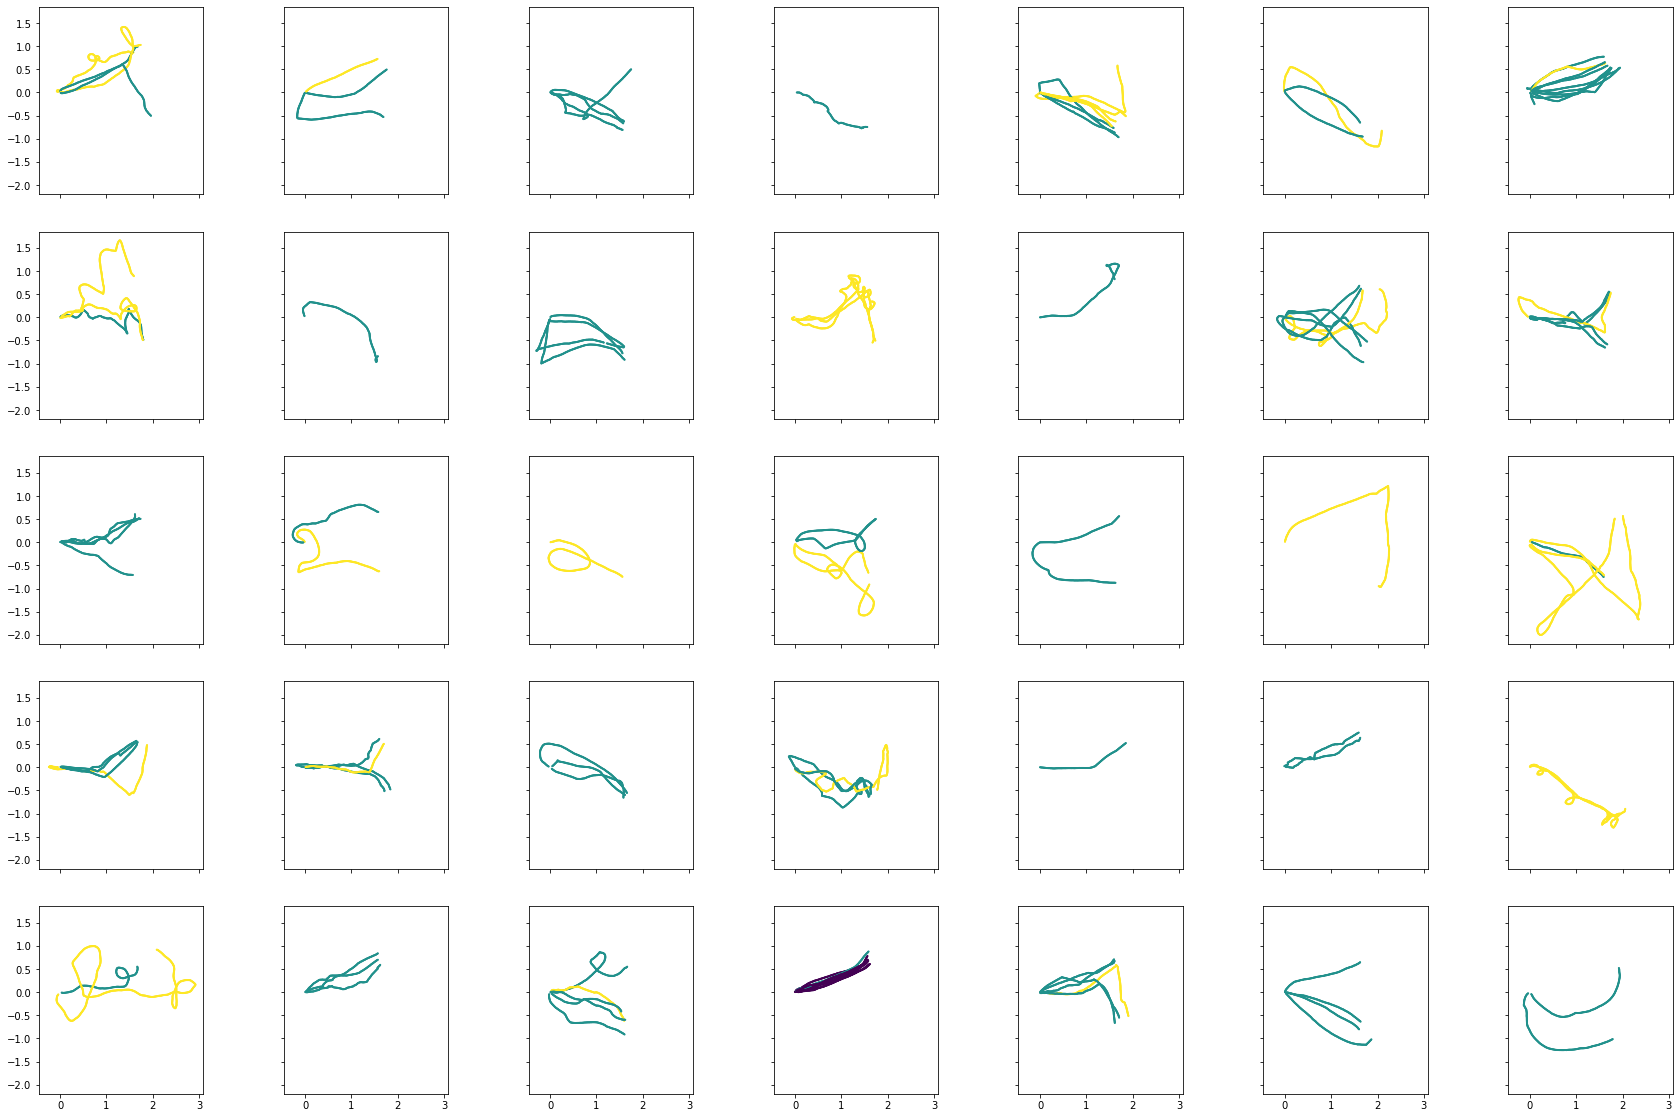

In [24]:
rows = 5
cols = 7
fig,ax = plt.subplots(rows,cols, figsize=(30,20), sharex=True, sharey=True)
colours = plt.cm.viridis(np.linspace(0,1,len(np.unique(df['track_type'].dropna()))))

fid = 0
for c in range(0,cols):
    for r in range(0,rows):
        ax[r,c].scatter(df.loc[df['uuid'] == np.unique(df['uuid'])[fid], 'rotated_x'], df.loc[df['uuid'] == np.unique(df['uuid'])[fid], 'rotated_y'], c=colours[df.loc[df['uuid'] == np.unique(df['uuid'])[fid], 'track_type']], s=1)
        ax[r,c].set_aspect('equal')
        fid += 1